In [2120]:
import pandas as pd
import json
import sklearn

In [2121]:
# Load cleaned charging data
charging_data: pd.DataFrame = pd.read_pickle('data/charging_modified.pkl')

# Drop unique columns or unimportant columns
charging_data = charging_data.drop(columns=['id', 'user_paymentRequired_values', 'user_modifiedAt', 'userID', 'stationID', 'spaceID'])

# Print head
display(charging_data.head())

# Print row count
print(f'Row count: {charging_data.shape[0]}')

,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,weekday,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTime,...,ChargingTimeHours,kWhPerMinute,month,userRegistered,user_requestedDeparture,user_minutesAvailable,user_milesRequested,user_kWhRequested,user_WhPerMile,user_kWhRequestFulfilment
0,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00,10.013,2,Wednesday,0 days 08:12:01,492.016667,8.200278,0 days 02:59:05,...,2.984722,0.055913,4,unregistered,None,NaN,NaN,NaN,NaN,NaN
1,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00,5.257,2,Wednesday,0 days 08:13:01,493.016667,8.216944,0 days 01:05:54,...,1.098333,0.079772,4,unregistered,None,NaN,NaN,NaN,NaN,NaN
2,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00,5.177,2,Wednesday,0 days 07:50:12,470.200000,7.836667,0 days 01:28:16,...,1.471111,0.058652,4,unregistered,None,NaN,NaN,NaN,NaN,NaN
3,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00,10.119,2,Wednesday,0 days 05:22:42,322.700000,5.378333,0 days 02:59:56,...,2.998889,0.056237,4,unregistered,None,NaN,NaN,NaN,NaN,NaN
4,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,2018-04-25 16:18:28+00:00,7.910,2,Wednesday,0 days 08:59:02,539.033333,8.983889,0 days 01:34:38,...,1.577222,0.083586,4,unregistered,None,NaN,NaN,NaN,NaN,NaN


Row count: 52924


# Preparing the data

## Basic data cleaning

In [2122]:
# Fix the data types
prepared_data = charging_data.astype(
    {
        'weekday': 'category',
        'kWhDelivered': 'float64', 
        'userRegistered': 'category'
    }
)

# If doneChargingTime is null, then the car is still charging
prepared_data['evIsDoneCharging'] = prepared_data['doneChargingTime'].isnull()

# Set ChargingTime where missing
def calc_charging_time(row):
    if pd.isnull(row['doneChargingTime']):
        return row['disconnectTime'] - row['connectionTime']
    else:
        return row['ChargingTime']

prepared_data['ChargingTime'] = prepared_data.apply(calc_charging_time, axis=1)

# Fill NoChargingTime with 0
prepared_data['NoChargingTime'] = prepared_data['NoChargingTime'].fillna(pd.Timedelta(seconds=0))

# Drop remaining columns with null values
prepared_data = prepared_data.dropna(axis=1)

# Display null values
display(prepared_data.isnull().sum())

connectionTime      0
disconnectTime      0
kWhDelivered        0
siteID              0
weekday             0
NoChargingTime      0
ChargingTime        0
month               0
userRegistered      0
evIsDoneCharging    0
dtype: int64

In [2123]:
# Get delta between connection and disconnect time
prepared_data['connectionDurationInMinutes'] = (prepared_data['disconnectTime'] - prepared_data['connectionTime']).dt.total_seconds() / 60

display(prepared_data.head())

,connectionTime,disconnectTime,kWhDelivered,siteID,weekday,NoChargingTime,ChargingTime,month,userRegistered,evIsDoneCharging,connectionDurationInMinutes
0,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,10.013,2,Wednesday,0 days 08:12:01,0 days 02:59:05,4,unregistered,False,671.100000
1,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,5.257,2,Wednesday,0 days 08:13:01,0 days 01:05:54,4,unregistered,False,558.916667
2,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,5.177,2,Wednesday,0 days 07:50:12,0 days 01:28:16,4,unregistered,False,558.466667
3,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,10.119,2,Wednesday,0 days 05:22:42,0 days 02:59:56,4,unregistered,False,502.633333
4,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,7.910,2,Wednesday,0 days 08:59:02,0 days 01:34:38,4,unregistered,False,633.666667


In [2124]:
# Label encode ordinal columns
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

prepared_data['weekday'] = label_encoder.fit_transform(prepared_data['weekday'])

# User registered is not really ordinal, but we will treat it as such and then convert it to boolean
prepared_data['userRegistered'] = label_encoder.fit_transform(prepared_data['userRegistered'])
prepared_data = prepared_data.astype({'userRegistered': 'bool'})

display(prepared_data.head())

,connectionTime,disconnectTime,kWhDelivered,siteID,weekday,NoChargingTime,ChargingTime,month,userRegistered,evIsDoneCharging,connectionDurationInMinutes
0,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,10.013,2,6,0 days 08:12:01,0 days 02:59:05,4,True,False,671.100000
1,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,5.257,2,6,0 days 08:13:01,0 days 01:05:54,4,True,False,558.916667
2,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,5.177,2,6,0 days 07:50:12,0 days 01:28:16,4,True,False,558.466667
3,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,10.119,2,6,0 days 05:22:42,0 days 02:59:56,4,True,False,502.633333
4,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,7.910,2,6,0 days 08:59:02,0 days 01:34:38,4,True,False,633.666667


In [2125]:
# One hot encode nominal columns
# this increases the dimensionality of the data (labels encoding would imply an ordinal relationship between the values)
prepared_data = pd.get_dummies(prepared_data, columns=['siteID'])
display(prepared_data.head())

,connectionTime,disconnectTime,kWhDelivered,weekday,NoChargingTime,ChargingTime,month,userRegistered,evIsDoneCharging,connectionDurationInMinutes,siteID_1,siteID_2
0,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,10.013,6,0 days 08:12:01,0 days 02:59:05,4,True,False,671.100000,False,True
1,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,5.257,6,0 days 08:13:01,0 days 01:05:54,4,True,False,558.916667,False,True
2,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,5.177,6,0 days 07:50:12,0 days 01:28:16,4,True,False,558.466667,False,True
3,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,10.119,6,0 days 05:22:42,0 days 02:59:56,4,True,False,502.633333,False,True
4,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,7.910,6,0 days 08:59:02,0 days 01:34:38,4,True,False,633.666667,False,True


In [2126]:
# Show null values
prepared_data.isnull().sum()

connectionTime                 0
disconnectTime                 0
kWhDelivered                   0
weekday                        0
NoChargingTime                 0
ChargingTime                   0
month                          0
userRegistered                 0
evIsDoneCharging               0
connectionDurationInMinutes    0
siteID_1                       0
siteID_2                       0
dtype: int64

## Cyclic encoding of time

In [2127]:
def encode_to_cyclic(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

def expand_datetime_to_columns(data, col):
    data[col + 'Month'] = data[col].dt.month
    data[col + 'Day'] = data[col].dt.day
    data[col + 'Hour'] = data[col].dt.hour
    return data

# Split connection into year, month, day, hour
prepared_data = expand_datetime_to_columns(prepared_data, 'connectionTime')
prepared_data = expand_datetime_to_columns(prepared_data, 'disconnectTime')

# Encode the time components to cyclic
prepared_data = encode_to_cyclic(prepared_data, 'connectionTimeMonth', 12)
prepared_data = encode_to_cyclic(prepared_data, 'disconnectTimeMonth', 12)

prepared_data = encode_to_cyclic(prepared_data, 'connectionTimeDay', 31)
prepared_data = encode_to_cyclic(prepared_data, 'disconnectTimeDay', 31)

prepared_data = encode_to_cyclic(prepared_data, 'connectionTimeHour', 24)
prepared_data = encode_to_cyclic(prepared_data, 'disconnectTimeHour', 24)

display(prepared_data.head())

,connectionTime,disconnectTime,kWhDelivered,weekday,NoChargingTime,ChargingTime,month,userRegistered,evIsDoneCharging,connectionDurationInMinutes,...,disconnectTimeMonth_sin,disconnectTimeMonth_cos,connectionTimeDay_sin,connectionTimeDay_cos,disconnectTimeDay_sin,disconnectTimeDay_cos,connectionTimeHour_sin,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos
0,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,10.013,6,0 days 08:12:01,0 days 02:59:05,4,True,False,671.100000,...,0.866025,-0.5,-0.937752,0.347305,-0.848644,0.528964,-0.258819,-0.965926,0.000000,1.000000
1,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,5.257,6,0 days 08:13:01,0 days 01:05:54,4,True,False,558.916667,...,0.866025,-0.5,-0.937752,0.347305,-0.937752,0.347305,-0.258819,-0.965926,-0.258819,0.965926
2,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,5.177,6,0 days 07:50:12,0 days 01:28:16,4,True,False,558.466667,...,0.866025,-0.5,-0.937752,0.347305,-0.937752,0.347305,-0.500000,-0.866025,-0.258819,0.965926
3,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,10.119,6,0 days 05:22:42,0 days 02:59:56,4,True,False,502.633333,...,0.866025,-0.5,-0.937752,0.347305,-0.937752,0.347305,-0.500000,-0.866025,-0.258819,0.965926
4,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,7.910,6,0 days 08:59:02,0 days 01:34:38,4,True,False,633.666667,...,0.866025,-0.5,-0.937752,0.347305,-0.848644,0.528964,-0.500000,-0.866025,0.258819,0.965926


In [2128]:
# Convert NoChargingTime and ChargingTime to minutes
prepared_data['NoChargingTimeInMinutes'] = prepared_data['NoChargingTime'].dt.total_seconds() / 60
prepared_data['ChargingTimeInMinutes'] = prepared_data['ChargingTime'].dt.total_seconds() / 60
prepared_data['NoChargingTimeInHours'] = prepared_data['NoChargingTime'].dt.total_seconds() / 60 / 60
prepared_data['ChargingTimeInHours'] = prepared_data['ChargingTime'].dt.total_seconds() / 60 / 60
prepared_data['ConnectionTimeInMinutes'] = (prepared_data['disconnectTime'] - prepared_data['connectionTime']).dt.total_seconds() / 60
prepared_data['ConnectionTimeInHours'] = (prepared_data['disconnectTime'] - prepared_data['connectionTime']).dt.total_seconds() / 60 / 60
    
# Drop the original columns
prepared_data = prepared_data.drop(columns=['NoChargingTime', 'ChargingTime', 'connectionTime', 'disconnectTime', 'month'])

## Methods for clustering

In [2129]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

random_state = 42
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer


def kmean(data, n_clusters):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=random_state)
    labels = kmeans.fit_predict(data)
    return labels, kmeans

def pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    return pca_result

def pca_based_kmean(data, n_clusters):
    pca_result = pca(data)
    labels, kmeans = kmean(pca_result, n_clusters)
    return labels, kmeans, pca_result

def plot_kmeans(data, labels):
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i}')
    plt.legend()
    plt.show() 
    
def perform_kmeans_and_plot(data, n_clusters):
    labels, kmeans, pca_result = pca_based_kmean(data, n_clusters)
    plot_kmeans(pca_result, labels)
    return labels, kmeans, pca_result

def normalize_and_cluster(data: pd.DataFrame, n_clusters: int) -> tuple[pd.DataFrame, np.ndarray]:
    # Scale the data in the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    # Perform elbow
    kelbow_visualizer(KMeans(random_state=random_state, n_init='auto'), scaled_data, k=(2,10))

    # Perform clustering
    labels, kmeans, pca_result = perform_kmeans_and_plot(scaled_data, n_clusters)
    
    return labels

# Clustering

## Cluster without time components

In [2130]:
def remove_cos_sin_columns(data: pd.DataFrame):
    data.drop(columns=data.filter(regex='_sin$', axis=1).columns, inplace=True)
    data.drop(columns=data.filter(regex='_cos$', axis=1).columns, inplace=True)
    
prepared_data.head()

,kWhDelivered,weekday,userRegistered,evIsDoneCharging,connectionDurationInMinutes,siteID_1,siteID_2,connectionTimeMonth,connectionTimeDay,connectionTimeHour,...,connectionTimeHour_sin,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours
0,10.013,6,True,False,671.100000,False,True,4,25,13,...,-0.258819,-0.965926,0.000000,1.000000,492.016667,179.083333,8.200278,2.984722,671.100000,11.185000
1,5.257,6,True,False,558.916667,False,True,4,25,13,...,-0.258819,-0.965926,-0.258819,0.965926,493.016667,65.900000,8.216944,1.098333,558.916667,9.315278
2,5.177,6,True,False,558.466667,False,True,4,25,14,...,-0.500000,-0.866025,-0.258819,0.965926,470.200000,88.266667,7.836667,1.471111,558.466667,9.307778
3,10.119,6,True,False,502.633333,False,True,4,25,14,...,-0.500000,-0.866025,-0.258819,0.965926,322.700000,179.933333,5.378333,2.998889,502.633333,8.377222
4,7.910,6,True,False,633.666667,False,True,4,25,14,...,-0.500000,-0.866025,0.258819,0.965926,539.033333,94.633333,8.983889,1.577222,633.666667,10.561111


In [2131]:
def clustify(data: pd.DataFrame, display_data: pd.DataFrame, columns_use_for_clustering: list[str], n_clusters: int = 4):
    df_without_time_component = data.copy()
    
    # Only use the following columns: ConnectionTimeHour, kWhDelivered
    df_without_time_component = df_without_time_component[columns_use_for_clustering]
        
    # Perform clustering
    labels = normalize_and_cluster(df_without_time_component, n_clusters)
    
    # Apply to the original dataset
    labeled_dataset = display_data.copy()
    labeled_dataset['cluster'] = labels
    labeled_dataset = labeled_dataset.groupby('cluster')
    
    for name, group in labeled_dataset:
        print(f'Cluster - {name}')
        display(group.describe())

## Whole dataset

### Cluster without time components

,kWhDelivered,weekday,userRegistered,evIsDoneCharging,connectionDurationInMinutes,siteID_1,siteID_2,connectionTimeMonth,connectionTimeDay,connectionTimeHour,...,connectionTimeHour_sin,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours
0,10.013,6,True,False,671.100000,False,True,4,25,13,...,-0.258819,-0.965926,0.000000,1.000000,492.016667,179.083333,8.200278,2.984722,671.100000,11.185000
1,5.257,6,True,False,558.916667,False,True,4,25,13,...,-0.258819,-0.965926,-0.258819,0.965926,493.016667,65.900000,8.216944,1.098333,558.916667,9.315278
2,5.177,6,True,False,558.466667,False,True,4,25,14,...,-0.500000,-0.866025,-0.258819,0.965926,470.200000,88.266667,7.836667,1.471111,558.466667,9.307778
3,10.119,6,True,False,502.633333,False,True,4,25,14,...,-0.500000,-0.866025,-0.258819,0.965926,322.700000,179.933333,5.378333,2.998889,502.633333,8.377222
4,7.910,6,True,False,633.666667,False,True,4,25,14,...,-0.500000,-0.866025,0.258819,0.965926,539.033333,94.633333,8.983889,1.577222,633.666667,10.561111


/home/s0pex/Git/UzK/AA_Team_9_WS23/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/s0pex/Git/UzK/AA_Team_9_WS23/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/s0pex/Git/UzK/AA_Team_9_WS23/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/s0pex/Git/UzK/AA_Team_9_WS23/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplica

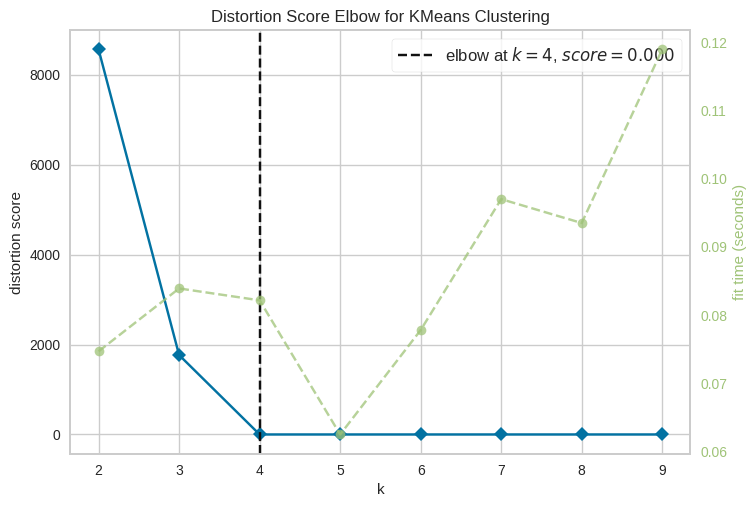

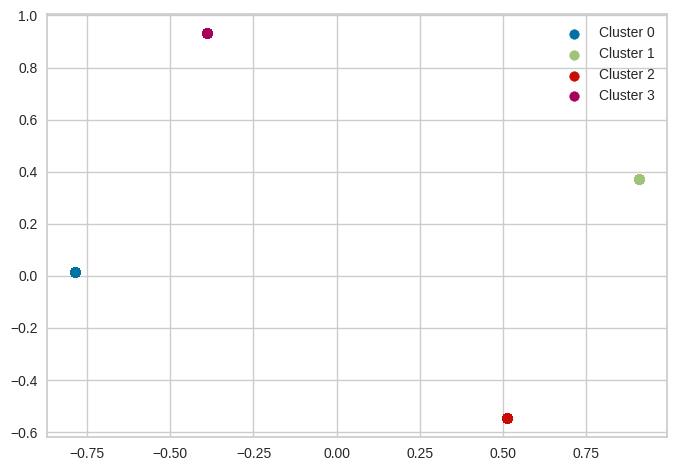

Cluster - 0


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,2.381700e+04,...,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.000000,23817.0
mean,14.505959,3.391779,452.118655,6.485997,15.600369,14.743125,6.498384,15.646849,11.474787,3.223064e-02,...,-0.499270,-0.160456,0.788120,194.261095,257.857560,3.237685,4.297626,452.118655,7.535311,0.0
std,10.922208,2.228406,185.108719,3.655867,8.645819,3.920419,3.654883,8.635367,10.291521,6.883309e-01,...,0.639938,0.476207,0.355475,169.129944,147.896842,2.818832,2.464947,185.108719,3.085145,0.0
min,0.502000,0.000000,8.866667,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000e+00,...,-1.000000,-1.000000,-1.000000,0.000000,6.933333,0.000000,0.115556,8.866667,0.147778,0.0
25%,6.912000,1.000000,294.950000,3.000000,8.000000,13.000000,3.000000,8.000000,1.000000,-5.000000e-01,...,-0.866025,-0.500000,0.707107,30.416667,143.733333,0.506944,2.395556,294.950000,4.915833,0.0
50%,11.603000,4.000000,524.233333,7.000000,15.000000,14.000000,7.000000,15.000000,16.000000,-2.449294e-16,...,-0.866025,-0.258819,0.965926,171.833333,227.250000,2.863889,3.787500,524.233333,8.737222,0.0
75%,17.297000,5.000000,587.166667,10.000000,23.000000,16.000000,10.000000,23.000000,22.000000,8.660254e-01,...,-0.258819,0.258819,0.965926,326.966667,336.583333,5.449444,5.609722,587.166667,9.786111,0.0
max,66.971000,6.000000,3248.866667,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.000000e+00,...,1.000000,1.000000,1.000000,3003.316667,1516.833333,50.055278,25.280556,3248.866667,54.147778,0.0


Cluster - 1


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,1.386900e+04,...,1.386900e+04,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.000000,13869.0
mean,7.272457,3.121494,333.765152,7.351143,16.046002,13.321220,7.362968,16.053573,10.048237,-3.824782e-01,...,3.821286e-02,-0.047294,0.569713,152.591081,181.174072,2.543185,3.019568,333.765152,5.562753,1.0
std,5.979187,2.126723,391.208931,2.241864,8.864907,7.012844,2.240141,8.869065,9.118688,6.051385e-01,...,6.931914e-01,0.616014,0.542002,309.249163,205.722801,5.154153,3.428713,391.208931,6.520149,0.0
min,0.501000,0.000000,5.250000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000e+00,...,-1.000000e+00,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,5.250000,0.087500,1.0
25%,2.252000,1.000000,105.116667,6.000000,8.000000,7.000000,6.000000,8.000000,1.000000,-8.660254e-01,...,-7.071068e-01,-0.500000,0.258819,0.133333,63.700000,0.002222,1.061667,105.116667,1.751944,1.0
50%,6.089000,4.000000,249.833333,8.000000,16.000000,15.000000,8.000000,16.000000,5.000000,-5.000000e-01,...,-1.836970e-16,0.000000,0.866025,43.900000,126.166667,0.731667,2.102778,249.833333,4.163889,1.0
75%,11.640000,5.000000,507.933333,9.000000,24.000000,18.000000,9.000000,24.000000,20.000000,1.224647e-16,...,7.071068e-01,0.500000,0.965926,224.966667,238.400000,3.749444,3.973333,507.933333,8.465556,1.0
max,61.550000,6.000000,14716.150000,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.000000e+00,...,1.000000e+00,1.000000,1.000000,8450.450000,6780.583333,140.840833,113.009722,14716.150000,245.269167,1.0


Cluster - 2


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,1.333000e+04,...,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.000000,13330.0
mean,10.645785,3.169842,381.576728,6.554164,15.461815,14.947337,6.565641,15.569092,8.386272,4.342787e-02,...,-0.025620,0.016297,0.667076,199.251859,182.324869,3.320864,3.038748,381.576728,6.359612,2.0
std,9.583150,2.202235,334.669026,3.838019,8.544232,5.962515,3.836843,8.523563,9.023482,6.933583e-01,...,0.606250,0.582758,0.463874,281.742543,198.570156,4.695709,3.309503,334.669026,5.577817,0.0
min,0.510000,0.000000,4.100000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000e+00,...,-1.000000,-1.000000,-1.000000,0.000000,4.100000,0.000000,0.068333,4.100000,0.068333,2.0
25%,4.375250,1.000000,165.133333,3.000000,8.000000,15.000000,3.000000,8.000000,1.000000,-5.000000e-01,...,-0.500000,-0.500000,0.500000,0.216667,78.454167,0.003611,1.307569,165.133333,2.752222,2.0
50%,7.744500,4.000000,378.066667,7.000000,15.000000,16.000000,7.000000,15.000000,3.000000,-2.449294e-16,...,-0.258819,0.000000,0.866025,120.283333,124.116667,2.004722,2.068611,378.066667,6.301111,2.0
75%,13.548000,5.000000,527.841667,10.000000,23.000000,18.000000,10.000000,23.000000,19.000000,8.660254e-01,...,0.500000,0.500000,0.965926,345.400000,235.350000,5.756667,3.922500,527.841667,8.797361,2.0
max,75.528000,6.000000,12859.316667,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.000000e+00,...,1.000000,1.000000,1.000000,9367.283333,12000.950000,156.121389,200.015833,12859.316667,214.321944,2.0


Cluster - 3


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,...,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.0
mean,6.103819,3.203878,380.218920,8.404088,15.868973,15.455975,8.410377,16.047170,12.853249,-0.528398,...,-0.359358,-0.261390,0.735646,108.227935,271.990985,1.803799,4.533183,380.218920,6.336982,3.0
std,6.540978,2.200692,237.937061,2.854398,8.254768,4.215069,2.856255,8.252878,10.036559,0.630370,...,0.690306,0.474221,0.407211,184.671214,234.010838,3.077854,3.900181,237.937061,3.965618,0.0
min,0.502000,0.000000,7.950000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.000000,7.950000,0.000000,0.132500,7.950000,0.132500,3.0
25%,0.844000,1.000000,192.766667,8.000000,9.000000,14.000000,8.000000,9.000000,1.000000,-1.000000,...,-0.866025,-0.500000,0.707107,0.000000,67.270833,0.000000,1.121181,192.766667,3.212778,3.0
50%,3.281000,4.000000,378.650000,9.000000,17.000000,15.000000,9.000000,17.000000,18.000000,-0.866025,...,-0.707107,-0.258819,0.965926,13.608333,220.833333,0.226806,3.680556,378.650000,6.310833,3.0
75%,10.469500,5.000000,555.662500,10.000000,22.000000,18.000000,10.000000,22.000000,22.000000,-0.500000,...,0.258819,0.000000,0.965926,149.079167,472.358333,2.484653,7.872639,555.662500,9.261042,3.0
max,36.898000,6.000000,3524.400000,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.000000,...,1.000000,1.000000,1.000000,3432.400000,3447.433333,57.206667,57.457222,3524.400000,58.740000,3.0


In [2132]:
display(prepared_data.head())

clustify(prepared_data, prepared_data, ['siteID_1', 'siteID_2', 'userRegistered'], 4)

### Cluster per Site

,kWhDelivered,weekday,userRegistered,evIsDoneCharging,connectionDurationInMinutes,siteID_1,siteID_2,connectionTimeMonth,connectionTimeDay,connectionTimeHour,...,connectionTimeHour_sin,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours
8184,9.583,6,True,True,485.366667,True,False,9,5,11,...,2.588190e-01,-0.965926,-0.965926,0.258819,0.0,485.366667,0.0,8.089444,485.366667,8.089444
8185,7.114,6,False,True,180.883333,True,False,9,5,11,...,2.588190e-01,-0.965926,-0.500000,-0.866025,0.0,180.883333,0.0,3.014722,180.883333,3.014722
8187,11.774,6,False,True,714.966667,True,False,9,5,12,...,1.224647e-16,-1.000000,0.000000,1.000000,0.0,714.966667,0.0,11.916111,714.966667,11.916111
8188,6.280,6,False,True,581.450000,True,False,9,5,12,...,1.224647e-16,-1.000000,-0.500000,0.866025,0.0,581.450000,0.0,9.690833,581.450000,9.690833
8189,7.022,6,False,True,624.400000,True,False,9,5,13,...,-2.588190e-01,-0.965926,-0.258819,0.965926,0.0,624.400000,0.0,10.406667,624.400000,10.406667


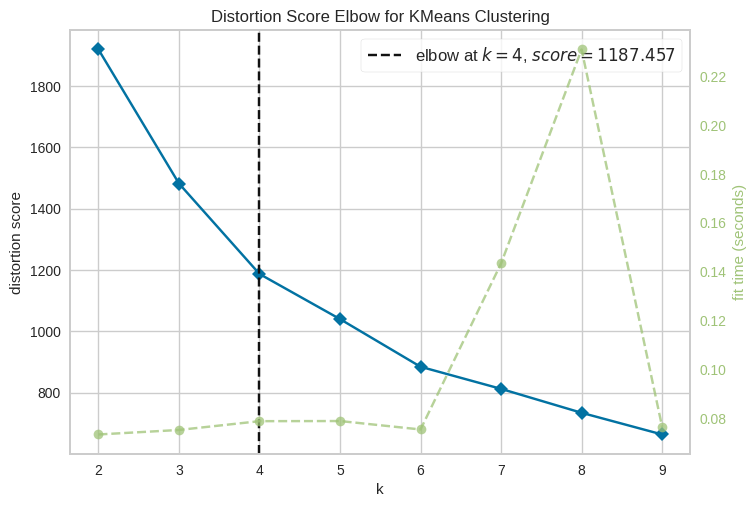

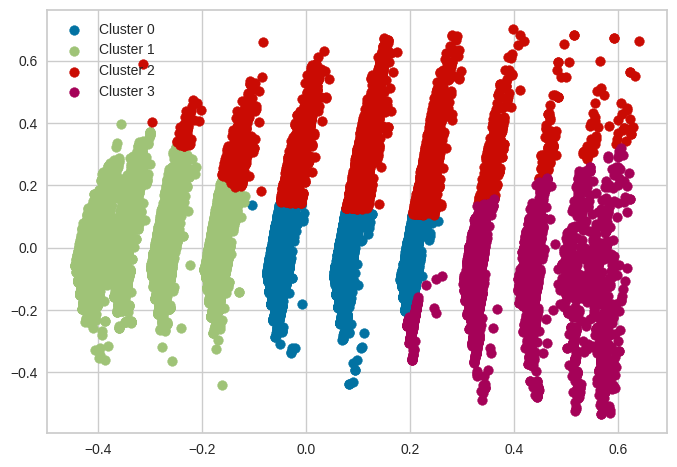

Cluster - 0


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,1.164300e+04,...,1.164300e+04,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.000000,11643.0
mean,9.935602,3.496006,485.869716,6.650348,15.504595,15.688482,6.668986,15.532423,8.881302,-2.836661e-02,...,-4.716539e-01,-0.039189,0.973456,242.833635,243.036080,4.047227,4.050601,485.869716,8.097829,0.0
std,5.076668,2.174815,183.511015,3.679941,8.597204,3.166500,3.680089,8.587657,10.956403,7.035679e-01,...,6.514584e-01,0.197015,0.109717,180.694356,148.912213,3.011573,2.481870,183.511015,3.058517,0.0
min,0.502000,0.000000,9.516667,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000e+00,...,-1.000000e+00,-0.500000,-1.000000,0.000000,6.933333,0.000000,0.115556,9.516667,0.158611,0.0
25%,6.121000,1.000000,374.900000,3.000000,8.000000,14.000000,3.000000,8.000000,0.000000,-5.000000e-01,...,-8.660254e-01,-0.258819,0.965926,57.391667,133.375000,0.956528,2.222917,374.900000,6.248333,0.0
50%,9.374000,4.000000,563.716667,7.000000,15.000000,14.000000,7.000000,15.000000,1.000000,-2.449294e-16,...,-8.660254e-01,0.000000,0.965926,265.000000,207.866667,4.416667,3.464444,563.716667,9.395278,0.0
75%,13.210500,5.000000,601.891667,10.000000,23.000000,18.000000,10.000000,23.000000,23.000000,5.000000e-01,...,-1.836970e-16,0.000000,1.000000,386.791667,310.950000,6.446528,5.182500,601.891667,10.031528,0.0
max,40.017000,6.000000,3524.400000,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.000000e+00,...,1.000000e+00,0.258819,1.000000,3432.400000,829.116667,57.206667,13.818611,3524.400000,58.740000,0.0


Cluster - 1


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7.582000e+03,...,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.000000,7582.0
mean,10.995720,3.162490,363.800273,6.864416,15.984041,14.170931,6.864416,15.984701,20.188736,-7.611819e-02,...,-0.755971,-0.742000,0.495380,142.048782,221.751490,2.367480,3.695858,363.800273,6.063338,1.0
std,6.935127,2.300525,161.224054,3.303347,8.682844,1.974460,3.303347,8.682579,1.825847,7.018236e-01,...,0.361375,0.200907,0.404597,135.887452,127.205244,2.264791,2.120087,161.224054,2.687068,0.0
min,0.503000,0.000000,8.866667,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,-1.000000e+00,...,-1.000000,-1.000000,-0.866025,0.000000,8.866667,0.000000,0.147778,8.866667,0.147778,1.0
25%,6.135250,1.000000,245.516667,4.000000,9.000000,13.000000,4.000000,9.000000,19.000000,-8.660254e-01,...,-0.965926,-0.965926,0.258819,9.137500,138.704167,0.152292,2.311736,245.516667,4.091944,1.0
50%,10.086500,4.000000,361.816667,7.000000,16.000000,14.000000,7.000000,16.000000,21.000000,-2.449294e-16,...,-0.866025,-0.707107,0.707107,109.891667,206.658333,1.831528,3.444306,361.816667,6.030278,1.0
75%,13.857750,5.000000,502.804167,10.000000,23.000000,15.000000,10.000000,23.000000,22.000000,5.000000e-01,...,-0.707107,-0.500000,0.866025,246.450000,284.383333,4.107500,4.739722,502.804167,8.380069,1.0
max,43.764000,6.000000,3447.433333,12.000000,31.000000,22.000000,12.000000,31.000000,22.000000,1.000000e+00,...,0.965926,-0.500000,0.866025,661.200000,3447.433333,11.020000,57.457222,3447.433333,57.457222,1.0


Cluster - 2


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3.761000e+03,...,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.0
mean,34.627894,3.392449,537.023753,6.198352,15.476469,15.071789,6.214571,15.634406,8.502526,1.117880e-01,...,-0.607810,-0.003299,0.941476,114.743020,422.280732,1.912384,7.038012,537.023753,8.950396,2.0
std,9.723217,2.222751,133.754295,3.813053,8.612185,2.271506,3.809766,8.591255,10.542067,6.808553e-01,...,0.461993,0.307621,0.137878,116.605663,123.542724,1.943428,2.059045,133.754295,2.229238,0.0
min,15.508000,0.000000,189.350000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000e+00,...,-1.000000,-0.965926,-0.965926,0.000000,103.550000,0.000000,1.725833,189.350000,3.155833,2.0
25%,27.388000,1.000000,488.916667,3.000000,8.000000,14.000000,3.000000,8.000000,0.000000,-5.000000e-01,...,-0.866025,-0.258819,0.965926,9.600000,328.966667,0.160000,5.482778,488.916667,8.148611,2.0
50%,33.791000,4.000000,560.366667,6.000000,15.000000,14.000000,6.000000,15.000000,1.000000,1.224647e-16,...,-0.866025,0.000000,0.965926,86.033333,420.133333,1.433889,7.002222,560.366667,9.339444,2.0
75%,40.071000,5.000000,602.216667,10.000000,23.000000,15.000000,10.000000,23.000000,23.000000,8.660254e-01,...,-0.707107,0.258819,1.000000,190.083333,516.666667,3.168056,8.611111,602.216667,10.036944,2.0
max,66.971000,6.000000,2899.233333,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.000000e+00,...,1.000000,1.000000,1.000000,1382.400000,1516.833333,23.040000,25.280556,2899.233333,48.320556,2.0


Cluster - 3


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2.739000e+03,...,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.0
mean,10.167667,3.451625,386.457326,6.470975,15.302665,12.353779,6.481563,15.493976,3.419131,8.996731e-02,...,0.340432,0.647765,0.563511,181.577589,204.879737,3.026293,3.414662,386.457326,6.440955,3.0
std,6.791791,2.201528,246.362367,4.013602,8.501796,8.679804,4.010843,8.492050,2.138283,6.721068e-01,...,0.735650,0.207580,0.468895,206.562643,154.933569,3.442711,2.582226,246.362367,4.106039,0.0
min,0.515000,0.000000,7.950000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-1.000000e+00,...,-1.000000,0.258819,-0.965926,0.000000,7.383333,0.000000,0.123056,7.950000,0.132500,3.0
25%,5.640000,1.000000,176.083333,2.000000,8.000000,2.000000,2.000000,8.000000,2.000000,-5.000000e-01,...,-0.500000,0.500000,0.500000,9.416667,110.533333,0.156944,1.842222,176.083333,2.934722,3.0
50%,8.412000,4.000000,312.900000,7.000000,15.000000,15.000000,7.000000,15.000000,3.000000,-2.449294e-16,...,0.707107,0.500000,0.707107,87.033333,159.066667,1.450556,2.651111,312.900000,5.215000,3.0
75%,13.198500,5.000000,633.800000,11.000000,23.000000,21.000000,11.000000,23.000000,4.000000,8.660254e-01,...,0.965926,0.866025,0.866025,327.258333,245.000000,5.454306,4.083333,633.800000,10.563333,3.0
max,40.013000,6.000000,2243.983333,12.000000,31.000000,23.000000,12.000000,31.000000,11.000000,1.000000e+00,...,1.000000,1.000000,0.965926,2136.516667,973.350000,35.608611,16.222500,2243.983333,37.399722,3.0


In [2133]:
office_data = prepared_data[prepared_data['siteID_1'] == True]
display(office_data.head())

clustify(office_data, office_data, ['connectionTimeHour_sin', 'disconnectTimeHour_sin', 'kWhDelivered', 'ChargingTimeInMinutes'], 4)

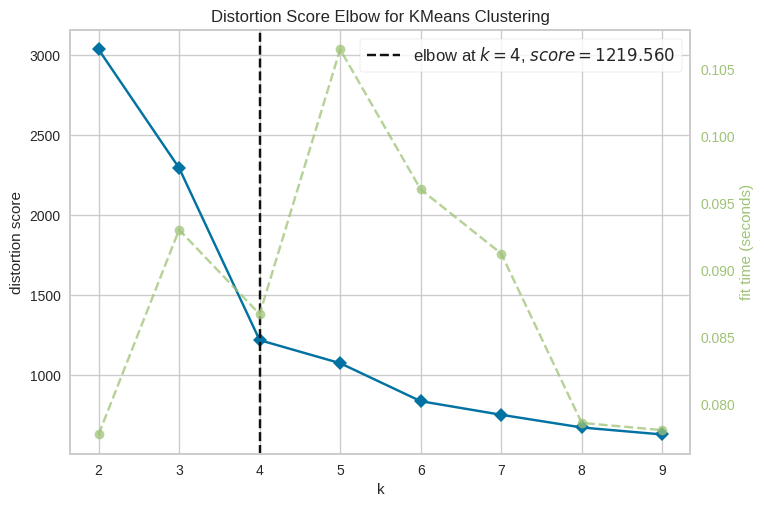

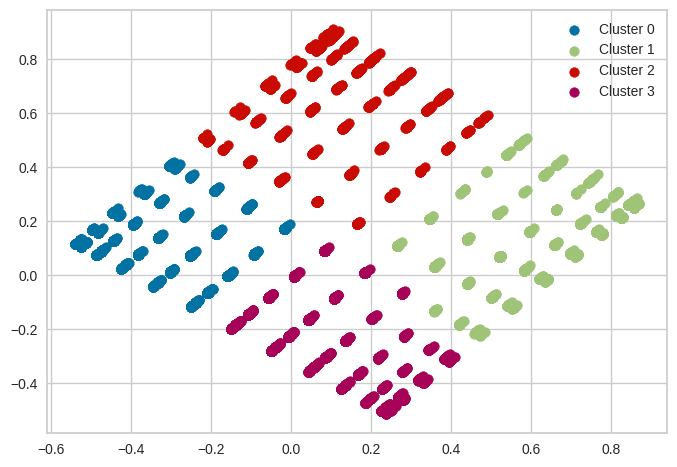

Cluster - 0


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,...,9.613000e+03,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.000000,9613.0
mean,7.507340,3.033912,255.917877,7.043275,15.903152,16.808176,7.044003,15.905545,20.447415,-0.195866,...,-2.739159e-01,-0.637139,0.511211,104.747798,151.170079,1.745797,2.519501,255.917877,4.265298,0.0
std,6.745325,2.110773,336.446233,3.010869,8.780516,2.389642,3.010842,8.780394,2.424230,0.680793,...,5.344825e-01,0.286691,0.500559,244.950092,203.186929,4.082502,3.386449,336.446233,5.607437,0.0
min,0.501000,0.000000,5.250000,1.000000,1.000000,13.000000,1.000000,1.000000,13.000000,-1.000000,...,-9.659258e-01,-1.000000,-0.965926,0.000000,0.433333,0.000000,0.007222,5.250000,0.087500,0.0
25%,2.733000,1.000000,94.516667,5.000000,8.000000,15.000000,5.000000,8.000000,19.000000,-0.866025,...,-7.071068e-01,-0.965926,0.258819,0.083333,62.583333,0.001389,1.043056,94.516667,1.575278,0.0
50%,5.747000,3.000000,199.800000,7.000000,16.000000,16.000000,7.000000,16.000000,21.000000,-0.500000,...,-5.000000e-01,-0.707107,0.707107,22.866667,110.666667,0.381111,1.844444,199.800000,3.330000,0.0
75%,10.719000,5.000000,357.766667,9.000000,24.000000,18.000000,9.000000,24.000000,23.000000,0.500000,...,-1.836970e-16,-0.258819,0.965926,143.083333,198.200000,2.384722,3.303333,357.766667,5.962778,0.0
max,58.873000,6.000000,12859.316667,12.000000,31.000000,23.000000,12.000000,31.000000,23.000000,1.000000,...,9.659258e-01,-0.258819,0.965926,8318.166667,12000.950000,138.636111,200.015833,12859.316667,214.321944,0.0


Cluster - 1


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,...,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.0
mean,7.973448,3.173377,163.479069,7.296810,16.102750,2.847085,7.296150,16.112431,3.881848,-0.276791,...,0.787545,0.734173,0.478433,49.810972,113.668097,0.830183,1.894468,163.479069,2.724651,1.0
std,6.822699,2.118277,309.290377,2.945985,8.726162,4.501778,2.946015,8.720644,1.998765,0.662442,...,0.329357,0.232605,0.421946,222.552350,180.404076,3.709206,3.006735,309.290377,5.154840,0.0
min,0.501000,0.000000,4.100000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-1.000000,...,-1.000000,0.258819,-0.965926,0.000000,2.883333,0.000000,0.048056,4.100000,0.068333,1.0
25%,2.935000,1.000000,65.683333,5.000000,9.000000,1.000000,5.000000,9.000000,3.000000,-0.866025,...,0.707107,0.500000,0.258819,0.083333,48.333333,0.001389,0.805556,65.683333,1.094722,1.0
50%,6.330000,4.000000,108.316667,8.000000,16.000000,2.000000,8.000000,16.000000,4.000000,-0.500000,...,0.965926,0.707107,0.500000,0.150000,84.116667,0.002500,1.401944,108.316667,1.805278,1.0
75%,11.723000,5.000000,172.400000,10.000000,24.000000,3.000000,10.000000,24.000000,5.000000,0.500000,...,0.965926,0.965926,0.707107,35.133333,131.616667,0.585556,2.193611,172.400000,2.873333,1.0
max,60.977000,6.000000,6973.666667,12.000000,31.000000,23.000000,12.000000,31.000000,11.000000,1.000000,...,1.000000,1.000000,0.965926,5400.483333,6780.583333,90.008056,113.009722,6973.666667,116.227778,1.0


Cluster - 2


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,...,1.537000e+03,1.537000e+03,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.0
mean,16.051957,3.001301,754.484602,7.189980,15.823032,4.459987,7.192583,15.844502,14.655823,-0.263177,...,3.316147e-01,-5.678440e-01,-0.327966,451.533507,302.951095,7.525558,5.049185,754.484602,12.574743,2.0
std,12.873766,2.002602,739.423159,2.689743,8.797189,3.597217,2.689800,8.803920,5.019554,0.644131,...,6.825783e-01,3.227945e-01,0.682764,659.496117,305.982396,10.991602,5.099707,739.423159,12.323719,0.0
min,0.508175,0.000000,5.116667,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,0.000000,5.050000,0.000000,0.084167,5.116667,0.085278,2.0
25%,6.837000,1.000000,520.166667,5.000000,8.000000,2.000000,5.000000,8.000000,13.000000,-0.866025,...,6.123234e-17,-8.660254e-01,-0.866025,90.633333,125.766667,1.510556,2.096111,520.166667,8.669444,2.0
50%,13.295000,3.000000,684.900000,7.000000,16.000000,4.000000,7.000000,16.000000,15.000000,-0.500000,...,5.000000e-01,-7.071068e-01,-0.707107,364.983333,241.166667,6.083056,4.019444,684.900000,11.415000,2.0
75%,16.171000,5.000000,819.850000,9.000000,23.000000,6.000000,9.000000,23.000000,17.000000,0.500000,...,8.660254e-01,-2.588190e-01,0.258819,565.383333,383.383333,9.423056,6.389722,819.850000,13.664167,2.0
max,75.528000,6.000000,14716.150000,12.000000,31.000000,12.000000,12.000000,31.000000,23.000000,1.000000,...,1.000000e+00,1.224647e-16,1.000000,9367.283333,6265.700000,156.121389,104.428333,14716.150000,245.269167,2.0


Cluster - 3


,kWhDelivered,weekday,connectionDurationInMinutes,connectionTimeMonth,connectionTimeDay,connectionTimeHour,disconnectTimeMonth,disconnectTimeDay,disconnectTimeHour,connectionTimeMonth_sin,...,connectionTimeHour_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,NoChargingTimeInMinutes,ChargingTimeInMinutes,NoChargingTimeInHours,ChargingTimeInHours,ConnectionTimeInMinutes,ConnectionTimeInHours,cluster
count,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,1.150400e+04,...,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.0
mean,9.535013,3.246262,465.282765,6.727921,15.495828,17.613700,6.754781,15.620567,1.253303,-1.026006e-01,...,-0.110176,0.280086,0.887413,247.303071,217.979694,4.121718,3.632995,465.282765,7.754713,3.0
std,8.276791,2.240386,232.567515,3.379685,8.635237,2.572656,3.378590,8.617575,1.532739,6.920644e-01,...,0.573882,0.276205,0.240358,234.567031,175.979000,3.909451,2.932983,232.567515,3.876125,0.0
min,0.502000,0.000000,7.033333,1.000000,1.000000,13.000000,1.000000,1.000000,0.000000,-1.000000e+00,...,-0.965926,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,7.033333,0.117222,3.0
25%,4.016000,1.000000,351.233333,4.000000,8.000000,16.000000,4.000000,8.000000,0.000000,-8.660254e-01,...,-0.500000,0.000000,0.866025,48.754167,93.529167,0.812569,1.558819,351.233333,5.853889,3.0
50%,7.287000,4.000000,497.816667,7.000000,15.000000,17.000000,7.000000,15.000000,1.000000,-2.449294e-16,...,-0.258819,0.258819,0.965926,235.666667,157.183333,3.927778,2.619722,497.816667,8.296944,3.0
75%,13.190250,5.000000,563.412500,10.000000,23.000000,20.000000,10.000000,23.000000,2.000000,5.000000e-01,...,0.500000,0.500000,1.000000,396.637500,308.433333,6.610625,5.140556,563.412500,9.390208,3.0
max,61.114000,6.000000,6260.183333,12.000000,31.000000,23.000000,12.000000,31.000000,12.000000,1.000000e+00,...,0.965926,1.000000,1.000000,4865.350000,6077.983333,81.089167,101.299722,6260.183333,104.336389,3.0


In [2134]:
caltech_data = prepared_data[prepared_data['siteID_2'] == True]
clustify(caltech_data, caltech_data, ['connectionTimeHour_sin', 'disconnectTimeHour_sin', 'kWhDelivered', 'ChargingTimeInMinutes'], 4)